### Importing Required Packages

In [0]:
from pyspark.sql.functions import *
import pyspark.sql.functions as f
import pyspark.sql.types as t
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import lightgbm as lgbm
import shap
import os

In [0]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder,StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold,cross_val_score
import sklearn.metrics as sk_metrics
from sklearn.metrics import r2_score

In [0]:
#Setting to prevent OoM issue while handling large chunk of data
spark.conf.set("spark.sql.execution.arrow.enabled", "false")
spark.conf.set("spark.sql.execution.arrow.pyspark.fallback.enabled","false")

### Input Parameters

In [0]:
dbutils.widgets.removeAll()

In [0]:
dbutils.widgets.text("Country Name", "Germany")
dbutils.widgets.text("Product Name", "TRELEGY")
dbutils.widgets.text("Target DB Name", "opportunity_engine")
dbutils.widgets.text("Target Table Name Prefix", "opportunityengine")
dbutils.widgets.text("Start Yearmonth", "202103")
dbutils.widgets.text("End Yearmonth", "202209")

In [0]:
country_name = dbutils.widgets.get("Country Name")
product_name = dbutils.widgets.get("Product Name")
tgt_dbname = dbutils.widgets.get("Target DB Name")
tgt_tblname_prefix = dbutils.widgets.get("Target Table Name Prefix")
start_yearmonth = dbutils.widgets.get("Start Yearmonth")
end_yearmonth = dbutils.widgets.get("End Yearmonth")

In [0]:
TrainCV= spark.sql(f"select * from {tgt_dbname}.{tgt_tblname_prefix.lower()}_{country_name.lower()}_{product_name.lower()} where Initiation_Candidate=0 and {start_yearmonth} <=yearmonth and yearmonth<= {end_yearmonth} ")
Test= spark.sql(f"select * from {tgt_dbname}.{tgt_tblname_prefix.lower()}_{country_name.lower()}_{product_name.lower()} where Initiation_Candidate=0 and yearmonth> {end_yearmonth} ")

In [0]:
#To be deleted
display(Test)

ACCOUNT_ID CORE_GSK_MDM_ID RX_GIGYA_ID CORE_GSK_SE_ID RX_EU5_GSK_NANO_BRICK CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED DO_NOT_CONTACT_STATUS_CHANGED_DATE CORE_GSK_EMAIL_CONSENT_DECLINED CORE_GSK_EMAIL_CONSENT_DECLINED_DATE RX_GSK_DO_NOT_MAIL_IND RX_GSK_DO_NOT_PHONE_IND CORE_GSK_PRIVACY_NOTICES_SERVED RX_ACCESS_INFORMATION NAME GENDER RX_ACADEMIC_TITLE RX_HCP_ACCOUNT_TYPE RX_MEDICAL_INTEREST SALUTATION SPECIALTY_1 SPECIALTY_2 RX_PRESCRIBER_IND RX_GOVERNMENT_OFFICIAL_IND RX_CLINICAL_INVESTIGATOR_IND RX_DISPENSING_HCP_IND RX_EE_IND SPEAKER_IND CURRENCY_CODE PRODUCT_ID RX_SEGMENT RX_ATTITUDINAL_SEGMENTATION RX_CUSTOMER_JOURNEY PRODUCT_NAME HAS_ACTIVE_PLAN EMAIL_CONSENT_DECLINED DO_NOT_CONTACT_STATUS_CHANGED SOURCE_ACCOUNT_AID NANOBRICK YEARMONTH VOL_ELEBRATO_ELLIPTA VOL_TRELEGY VOL_SITT VOL_TRIMBOW VOL_LABA/LAMA VOL_TRIMBOW_NEXTHALER_+_PI VOL_TRIXEO VOL_ICS/LABA SHARE_ELEBRATO_ELLIPTA SHARE_TRELEGY SHARE_SITT SHARE_TRIMBOW SHARE_LABA/LAMA SHARE_TRIMBOW_NEXTHALER_+_PI SHARE_TRIXEO SHARE_ICS/LABA SHARE_SPIOLTO_+_PI SHARE_FOSTER_NEXTHALER SHARE_ANORO_+_PI SHARE_RELVAR SHARE_FOSTER_GESAMT_+_PI SHARE_MDI SHARE_DPI SHARE_ONCE_DAILY SHARE_TWICE_DAILY AVG_UNIT AVG_SALES TOTAL_CALL_DURATION TOTAL_SLIDE_VIEWS TOTAL_F2F_CALL TOTAL_EDETAIL_CALLS_IPAD TOTAL_EDETAIL_CALLS TOTAL_SAMPLE_DROPS TOTAL_PHONE_CALL TOTAL_ITEM_DROP TOTAL_WEB_CALL TOTAL_MSL_EMAIL_CALL TOTAL_VIRTUAL_CALL TOTAL_CRM_EMAIL_SENT TOTAL_CRM_EMAIL_DELIVERED TOTAL_CRM_EMAIL_BOUNCED TOTAL_CRM_EMAIL_UNSUBSCRIBED TOTAL_CRM_EMAIL_OPENED TOTAL_CRM_EMAIL_CLICKED MAXIMUM_CLICK_COUNT AVERAGE_CLICK_COUNT TOTAL_EVENTS_INVITED TOTAL_EVENTS_ATTENDED MASS_EMAIL_CONSENT CRM_EMAIL_CONSENT TOTAL_WEBINAR_REGISTERD TOTAL_WEBINAR_ATTENDED_TIME TOTAL_PORTAL_VISITS TOTAL_PORTAL_TIME TOTAL_PORTAL_VIDEO_WATCH TOTAL_VIDEO_PAGE_VIEW TOTAL_CHAT_FINISHED TOTAL_WEB_SHOP_ORDER_CONFIRMATION TOTAL_STAY_INFORM TOTAL_REQUEST_REP TOTAL_DISTINCT_MASS_EMAIL_SENT TOTAL_DISTINCT_MASS_EMAIL_DELIVERED TOTAL_DISTINCT_MASS_EMAIL_BOUNCED TOTAL_DISTINCT_MASS_EMAIL_UNSUBSCRIBED TOTAL_DISTINCT_MASS_EMAIL_CLICKED TOTAL_DISTINCT_MASS_EMAIL_OPENED AVG_SAMPLE_DROPS_PER_F2F_CALL AVG_SLIDE_VIEWS_EDETAIL_CALLS AVG_F2F_CALLS_WITH_EDETAIL AVG_F2F_CALLS_OUT_OF_TOTAL_CALLS AVG_VIRTUAL_CALLS_OUT_OF_TOTAL_CALLS CALL_TYPE_WITH_MAX_INTERACTION CRM_EMAIL_OPEN_RATE CRM_EMAIL_CLICK_RATE CRM_EMAIL_CLICK_TO_OPEN_RATE CRM_EMAIL_SCORE PERCENT_ATTENDED_OF_INVITED PERCENT_PARTICIPATED_OF_REGISTERED AVG_VIDEO_PAGE_VIEW_PER_VISIT AVG_REQUEST_REP_PER_VISIT MASS_EMAIL_OPEN_RATE MASS_EMAIL_CLICK_RATE MASS_EMAIL_CLICK_TO_OPEN_RATE MASS_EMAIL_SCORE INITIATION_CANDIDATE 14758111 HCP8248280 null null 19013111 0 null 0 null 0 0 1 null Christine Stegmann F Doctor of Medicine Doctor null Mrs. Internal Medicine/Family Practice Family Medicine 0 0 0 0 0 0 GBP 26441 C Attitude 1 Conversion Trelegy 1 0 0 001580000088h2eAAA INT Flensburg 202211.0 7.5 45.5 102.0 45.5 136.0 0.5 3.0 386.5 0.07352941176470588 0.44607843137254904 0.1633306645316253 0.44607843137254904 0.2177742193755004 0.00490196078431373 0.02941176470588235 0.6188951160928743 0.08708133971291866 0.04880382775119617 0.17320574162679425 0.34545454545454546 0.34545454545454546 0.36749399519615694 0.6325060048038431 0.3026421136909528 0.6973578863090473 257.1111111111111 18393.444444444445 null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null null 0 14758111 HCP8248280 null null 19013111 0 null 0 null 0 0 1 null Christine Stegmann F Doctor of Medicine Doctor null Mrs. Internal Medicine/Family Practice Family Medicine 0 0 0 0 0 0 GBP 26441 C Attitude 1 Conversion Trelegy 1 0 0 001580000088h2eAAA INT Flensburg 202210.0 3.0 45.5 82.0 25.5 91.0 0.5 7.5 196.5 0.03658536585365854 0.5548780487804879 0.2219215155615697 0.31097560975609756 0.2462787550744249 0.00609756097560976 0.0914634146341463

In [0]:
print(TrainCV.count())
print(Test.count())

640916
101140


#### Data Preprocessing

In [0]:
def convert_toPandas(sparkdf):
  sparkdf_pd= sparkdf.toPandas()
  sparkdf_pd = sparkdf_pd.dropna(subset=['AVG_UNIT'])
  sparkdf_pd.replace(r'\s+', np.nan, regex=True)
  sparkdf_pd.fillna(value = np.nan,inplace=True) 
  sparkdf.unpersist()
  return sparkdf_pd
  

In [0]:
TrainCV_df = convert_toPandas(TrainCV)
Test_df = convert_toPandas(Test)

In [0]:
def data_conversion_split(df):
  X=df[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2', 'RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID', 'RX_ATTITUDINAL_SEGMENTATION','HAS_ACTIVE_PLAN', 'SHARE_ELEBRATO_ELLIPTA', 'SHARE_TRELEGY','SHARE_TRIMBOW','TOTAL_CALL_DURATION', 'TOTAL_SLIDE_VIEWS', 'TOTAL_F2F_CALL', 'TOTAL_EDETAIL_CALLS_IPAD', 'TOTAL_EDETAIL_CALLS', 'TOTAL_SAMPLE_DROPS', 'TOTAL_PHONE_CALL', 'TOTAL_ITEM_DROP', 'TOTAL_WEB_CALL', 'TOTAL_MSL_EMAIL_CALL', 'TOTAL_VIRTUAL_CALL', 'TOTAL_CRM_EMAIL_SENT', 'TOTAL_CRM_EMAIL_DELIVERED', 'TOTAL_CRM_EMAIL_BOUNCED', 'TOTAL_CRM_EMAIL_UNSUBSCRIBED', 'TOTAL_CRM_EMAIL_OPENED', 'TOTAL_CRM_EMAIL_CLICKED', 'MAXIMUM_CLICK_COUNT', 'AVERAGE_CLICK_COUNT', 'TOTAL_EVENTS_INVITED', 'TOTAL_EVENTS_ATTENDED', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT', 'TOTAL_WEBINAR_REGISTERD', 'TOTAL_WEBINAR_ATTENDED_TIME',    'TOTAL_PORTAL_VISITS', 'TOTAL_REQUEST_REP', 'TOTAL_DISTINCT_MASS_EMAIL_SENT', 'TOTAL_DISTINCT_MASS_EMAIL_DELIVERED', 'TOTAL_DISTINCT_MASS_EMAIL_BOUNCED', 'TOTAL_DISTINCT_MASS_EMAIL_UNSUBSCRIBED', 'TOTAL_DISTINCT_MASS_EMAIL_CLICKED', 'TOTAL_DISTINCT_MASS_EMAIL_OPENED','AVG_SAMPLE_DROPS_PER_F2F_CALL', 'MASS_EMAIL_OPEN_RATE', 'MASS_EMAIL_CLICK_RATE', 'MASS_EMAIL_CLICK_TO_OPEN_RATE', 'MASS_EMAIL_SCORE','AVG_SLIDE_VIEWS_EDETAIL_CALLS', 'AVG_F2F_CALLS_WITH_EDETAIL', 'AVG_F2F_CALLS_OUT_OF_TOTAL_CALLS', 'AVG_VIRTUAL_CALLS_OUT_OF_TOTAL_CALLS',  'CRM_EMAIL_OPEN_RATE', 'CRM_EMAIL_CLICK_RATE', 'CRM_EMAIL_CLICK_TO_OPEN_RATE', 'CRM_EMAIL_SCORE', 'PERCENT_ATTENDED_OF_INVITED', 'PERCENT_PARTICIPATED_OF_REGISTERED','TOTAL_PORTAL_VIDEO_WATCH']]
  Y=df[[ 'AVG_UNIT']]
  pd.set_option('mode.chained_assignment', None)  
  X[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT' ]]=X[['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT' ]].astype(str)
  return X,Y

In [0]:
X_TrainCV,Y_TrainCV = data_conversion_split(TrainCV_df)
X_Test,Y_Test=data_conversion_split(Test_df)

#### Define the preprocessing pipeline

In [0]:
def preprocessing_pipeline(numeric_features,categorical_features):
  numeric_transformer = Pipeline(
  steps=[("imputer_num", SimpleImputer(strategy='constant',fill_value=0)), 
         ("scaler", StandardScaler())]
                                )

  categorical_transformer = Pipeline(
  steps=[
    ("imputer_cat", SimpleImputer(strategy='constant',fill_value='missing')),  
    ("encoder", OneHotEncoder(handle_unknown="ignore"))]
                                    )
  preprocessor = ColumnTransformer(
  transformers=[
      ("cat", categorical_transformer, categorical_features),
      ("num", numeric_transformer, numeric_features)
      
                ]
                                  )
  return preprocessor


In [0]:
numeric_features = [ 'SHARE_ELEBRATO_ELLIPTA', 'SHARE_TRELEGY','SHARE_TRIMBOW','TOTAL_CALL_DURATION', 'TOTAL_SLIDE_VIEWS', 'TOTAL_F2F_CALL', 'TOTAL_EDETAIL_CALLS_IPAD', 'TOTAL_EDETAIL_CALLS', 'TOTAL_SAMPLE_DROPS', 'TOTAL_PHONE_CALL', 'TOTAL_ITEM_DROP', 'TOTAL_WEB_CALL', 'TOTAL_MSL_EMAIL_CALL', 'TOTAL_VIRTUAL_CALL', 'TOTAL_CRM_EMAIL_SENT', 'TOTAL_CRM_EMAIL_DELIVERED', 'TOTAL_CRM_EMAIL_BOUNCED', 'TOTAL_CRM_EMAIL_UNSUBSCRIBED', 'TOTAL_CRM_EMAIL_OPENED', 'TOTAL_CRM_EMAIL_CLICKED', 'MAXIMUM_CLICK_COUNT', 'AVERAGE_CLICK_COUNT', 'TOTAL_EVENTS_INVITED', 'TOTAL_EVENTS_ATTENDED',  'TOTAL_WEBINAR_REGISTERD', 'TOTAL_WEBINAR_ATTENDED_TIME',    'TOTAL_PORTAL_VISITS', 'TOTAL_REQUEST_REP', 'TOTAL_DISTINCT_MASS_EMAIL_SENT', 'TOTAL_DISTINCT_MASS_EMAIL_DELIVERED', 'TOTAL_DISTINCT_MASS_EMAIL_BOUNCED', 'TOTAL_DISTINCT_MASS_EMAIL_UNSUBSCRIBED', 'TOTAL_DISTINCT_MASS_EMAIL_CLICKED', 'TOTAL_DISTINCT_MASS_EMAIL_OPENED','AVG_SAMPLE_DROPS_PER_F2F_CALL', 'MASS_EMAIL_OPEN_RATE', 'MASS_EMAIL_CLICK_RATE', 'MASS_EMAIL_CLICK_TO_OPEN_RATE', 'MASS_EMAIL_SCORE','AVG_SLIDE_VIEWS_EDETAIL_CALLS', 'AVG_F2F_CALLS_WITH_EDETAIL', 'AVG_F2F_CALLS_OUT_OF_TOTAL_CALLS', 'AVG_VIRTUAL_CALLS_OUT_OF_TOTAL_CALLS',  'CRM_EMAIL_OPEN_RATE', 'CRM_EMAIL_CLICK_RATE', 'CRM_EMAIL_CLICK_TO_OPEN_RATE', 'CRM_EMAIL_SCORE', 'PERCENT_ATTENDED_OF_INVITED', 'PERCENT_PARTICIPATED_OF_REGISTERED','TOTAL_PORTAL_VIDEO_WATCH']

categorical_features=['CORE_GSK_DO_NOT_CONTACT_STATUS_CHANGED', 'CORE_GSK_EMAIL_CONSENT_DECLINED','RX_GSK_DO_NOT_MAIL_IND', 'RX_GSK_DO_NOT_PHONE_IND', 'CORE_GSK_PRIVACY_NOTICES_SERVED', 'RX_ACCESS_INFORMATION','GENDER', 'RX_ACADEMIC_TITLE', 'RX_HCP_ACCOUNT_TYPE', 'RX_MEDICAL_INTEREST', 'SALUTATION', 'SPECIALTY_1', 'SPECIALTY_2','RX_PRESCRIBER_IND', 'RX_GOVERNMENT_OFFICIAL_IND', 'RX_CLINICAL_INVESTIGATOR_IND', 'RX_DISPENSING_HCP_IND', 'RX_EE_IND', 'SPEAKER_IND', 'PRODUCT_ID','RX_ATTITUDINAL_SEGMENTATION', 'HAS_ACTIVE_PLAN', 'MASS_EMAIL_CONSENT', 'CRM_EMAIL_CONSENT']

preprocess= preprocessing_pipeline(numeric_features,categorical_features)

In [0]:
#Convert to Numpy Array after call to preprocess function
X_TrainCV_transformed=(preprocess.fit_transform(X_TrainCV)).toarray()
X_Test_transformed=(preprocess.fit_transform(X_Test)).toarray()
Y_TrainCV_transformed = (Y_TrainCV.astype(float)).to_numpy()
Y_Test_transformed = (Y_Test.astype(float)).to_numpy()

#### Define Custom loss function

In [0]:
from scipy.special import softmax
def grad_hess_mean_normal(y_true: np.ndarray, y_pred: np.ndarray):
        """Gradient and hessian for the combination mean aggregation - Normal
        distribution."""
        k = y_pred.shape[0]
        y = y_true  
        grad = np.ones(k) / k * (y_pred.mean() - y)
        hess = np.ones(k) / k**2
        return grad, hess
      
def grad_hess_sum_poisson(y_true: np.ndarray, y_pred: np.ndarray):
        """Gradient and hessian for the combination sum aggregation - Poisson
        distribution."""
        k = y_pred.shape[0]
        y = y_true   
        soft_y = softmax(y_pred)
        grad = np.ones(k) * (np.exp(y_pred) - y * soft_y)
        hess = np.ones(k) * (np.exp(y_pred) - y * soft_y * (1 - soft_y))
        return grad, hess

#### Perform K-Fold Cross validation

In [0]:
#Hyperparameters
hyperparameter_dictionary={
'boosting_type':	'gbdt',
'n_estimators':140,
'colsample_bytree':	1.0,
'early_stopping_rounds':None,
'importance_type':'split',
'learning_rate':0.01,
'max_depth':-1,
'min_child_samples':20,
'min_child_weight':	0.001,
'min_split_gain':	0.0,
'n_jobs':-1,
'num_leaves':	10,
'objective':'regression',
'random_state':	None,
'class_weight':None,
'reg_alpha':	0.0,
'reg_lambda':	0.0,
'subsample':	1.0,
'subsample_for_bin':200000,
'subsample_freq':	0,
'verbose':	-1
}

In [0]:
# Train a LightGBM model with the custom loss function and "learning from aggregate"
model = lgbm.LGBMRegressor(**hyperparameter_dictionary)
kfold = KFold(n_splits=5, shuffle=True, random_state=11)
scores1 = []
for train_index, test_index in kfold.split(X_TrainCV_transformed):
    Xtrain, Xcv = X_TrainCV_transformed[train_index], X_TrainCV_transformed[test_index]
    Ytrain, Ycv = Y_TrainCV_transformed[train_index], Y_TrainCV_transformed[test_index]
    model.fit(Xtrain, Ytrain.ravel(),eval_metric=[grad_hess_mean_normal])
    score1 = model.score(Xcv, Ycv)
    scores1.append(score1)
mean1=np.mean(scores1)
std1=np.std(scores1)
print(f'R2-score during Cross-validation are:{scores1}')
print(f"\nMean R2 score with standard deviation is: {mean1:.2f} +/- {std1:.2f}")

R2-score during Cross-validation are:[0.24008391712584454, 0.24308658491085655, 0.2462119617704015, 0.24431732259841632, 0.24413749015564834]

Mean R2 score with standard deviation is: 0.24 +/- 0.00


In [0]:
# Train a LightGBM model with the custom loss function and "learning from aggregate"
models = lgbm.LGBMRegressor(**hyperparameter_dictionary)
models.fit(X_TrainCV_transformed, Y_TrainCV_transformed.ravel(),eval_metric=[grad_hess_mean_normal])
Y_pred = models.predict(X_Test_transformed)
print(r2_score(Y_Test_transformed, Y_pred))

0.12625206590596705


###SHAP

In [0]:
#Add headers to transformed features and get SHAP values
feature_list=preprocess.transformers_[0][1]['encoder'].get_feature_names(categorical_features)
feature_list=feature_list.tolist()
feature_list.extend(numeric_features)
X_Test_df= pd.DataFrame(X_Test_transformed ,columns= feature_list)
explainer = shap.Explainer(models)
shap_values = explainer(X_Test_df)

In [0]:
def shap_plot(plot_function): 
    p=plot_function
    plt.savefig('shap.svg')
    plt.close()
    return p
    os.remove('shap.svg')

#### Bar plot for Feature Importance

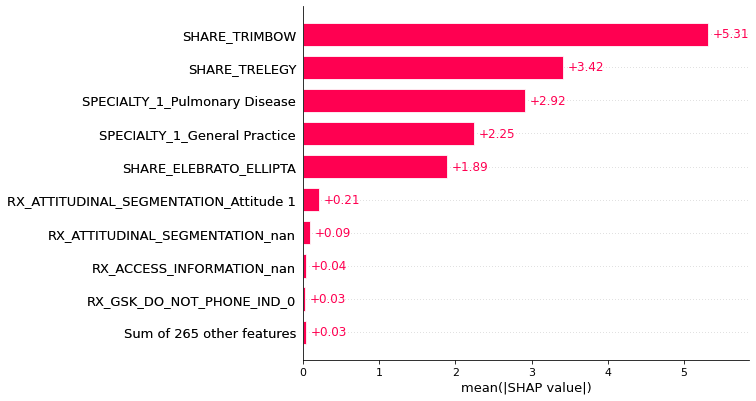

In [0]:
shap_plot(shap.plots.bar(shap_values.abs.mean(0)))

#### Beeswarm plot for Feature Importance

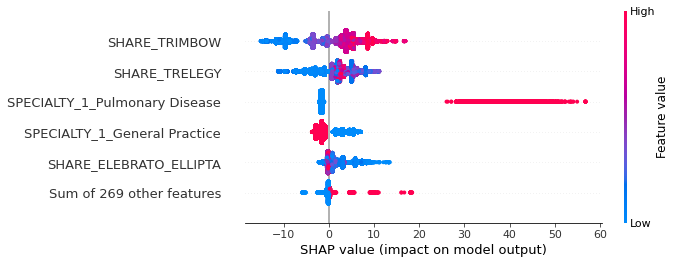

In [0]:
shap_plot(shap.plots.beeswarm(shap_values, max_display=6))

#### Store the results in database

In [0]:
Account_df = Test_df[['ACCOUNT_ID' , 'PRODUCT_NAME' ,'RX_EU5_GSK_NANO_BRICK' ,'NANOBRICK' , 'YEARMONTH' ,'SHARE_TRELEGY','SHARE_SITT' ,'CALL_TYPE_WITH_MAX_INTERACTION']]
Sales_df =pd.DataFrame(np.c_[Y_Test_transformed,Y_pred] ,columns= ["AVERAGE_SALES","PREDICTED_SALES"])
Account_df.reset_index(drop=True, inplace=True)
Sales_df.reset_index(drop=True, inplace=True)
Aggregates= pd.concat([Account_df,Sales_df], axis=1, ignore_index=False)

In [0]:
mySchema = t.StructType([ t.StructField("ACCOUNT_ID", t.LongType(), True)\
                       ,t.StructField("PRODUCT_NAME", t.StringType(), True)\
                      ,t.StructField("RX_EU5_GSK_NANO_BRICK", t.StringType(), True)\
                      ,t.StructField("NANOBRICK", t.StringType(), True)\
                       ,t.StructField("YEARMONTH", t.DoubleType(), True)\
                      ,t.StructField("SHARE_TRELEGY", t.FloatType(), True)\
                       ,t.StructField("SHARE_SITT", t.FloatType(), True)\
                       ,t.StructField("CALL_TYPE_WITH_MAX_INTERACTION", t.StringType(), True)\
                       ,t.StructField("AVERAGE_SALES", t.FloatType(), True)\
                       ,t.StructField("PREDICTED_SALES", t.FloatType(), True)\
                      ])
Py_Aggregates =  spark.createDataFrame(Aggregates,schema=mySchema)
Py_Aggregates.write.mode("overwrite").option("mergeSchema", "true").saveAsTable(
    f"{tgt_dbname}.aggregate_{country_name.lower()}_{product_name.lower()}"
)